In [125]:
import pandas as pd
from Historic_Crypto import HistoricalData  # Uses coinbase pro API
import datetime
import matplotlib.pyplot as plt
import numpy as np

# Get Data

Pull from Coinbase API

In [19]:
# df = HistoricalData('ETH-USD', 300,'2016-06-01-00-00').retrieve_data()
# df.to_csv('csv/ETH-USD-300-20160601-20220824.csv')

Or read from CSV

In [20]:
df = pd.read_csv('../csv/ETH-USD-300-20160601-20220824.csv', index_col=0)

In [21]:
df.head()

,low,high,open,close,volume
time,,,,,
2016-06-01 00:00:00,14.15,14.18,14.15,14.18,35.206821
2016-06-01 00:05:00,14.16,14.16,14.16,14.16,36.402093
2016-06-01 00:10:00,14.00,14.12,14.12,14.11,40.854990
2016-06-01 00:20:00,13.98,14.10,14.10,13.98,244.776964
2016-06-01 00:30:00,13.87,14.00,14.00,13.87,155.823036


In [22]:
df.tail()

,low,high,open,close,volume
time,,,,,
2022-08-24 09:15:00,1636.89,1640.00,1639.25,1638.76,643.336227
2022-08-24 09:20:00,1637.70,1642.87,1638.68,1638.30,1077.099748
2022-08-24 09:25:00,1635.55,1638.51,1638.22,1637.99,812.387659
2022-08-24 09:30:00,1634.14,1638.37,1637.97,1634.68,805.469833
2022-08-24 09:35:00,1632.74,1636.22,1634.65,1634.14,1098.373920


# Data Sanity Checks

In [23]:
# Make time a column instead of index

df.reset_index(inplace=True)
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,low,high,open,close,volume
0,2016-06-01 00:00:00,14.15,14.18,14.15,14.18,35.206821
1,2016-06-01 00:05:00,14.16,14.16,14.16,14.16,36.402093
2,2016-06-01 00:10:00,14.00,14.12,14.12,14.11,40.854990
3,2016-06-01 00:20:00,13.98,14.10,14.10,13.98,244.776964
4,2016-06-01 00:30:00,13.87,14.00,14.00,13.87,155.823036


In [26]:
# Check if there is data at every 5 min interval

lag_diff = df.time - df.time.shift(1)
print(lag_diff.min())
print(lag_diff.max())

0 days 00:05:00
0 days 05:50:00


In [139]:
# Pull cases where difference is greater than 10 mins.
# 10 mins cuz shorter TWAP on ETHUSD is 10 mins.

lag_diff[lag_diff > datetime.timedelta(minutes=10)].sort_values()

57009    0 days 00:15:00
5194     0 days 00:15:00
56996    0 days 00:15:00
56991    0 days 00:15:00
5198     0 days 00:15:00
               ...      
626      0 days 03:05:00
164929   0 days 03:10:00
81220    0 days 03:55:00
43772    0 days 05:10:00
68079    0 days 05:50:00
Name: time, Length: 1853, dtype: timedelta64[ns]

In [60]:
(1853/df.shape[0]) * 100

# 0.28% of the data is affected

0.2876337659999193

In [140]:
# Check some problematic rows manually

df.iloc[68077:68080]

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price
68077,2017-02-28 19:35:00,16.22,16.41,16.40,16.24,838.477119,300.0,1.035954
68078,2017-02-28 19:40:00,16.16,16.40,16.24,16.40,347.705348,300.0,0.985222
68079,2017-03-01 01:30:00,15.75,15.83,15.75,15.83,832.450212,21000.0,3.475610


In [66]:
df['lag_diff_time'] = (df.time - df.time.shift(1)).dt.seconds
df.head()

,time,low,high,open,close,volume,lag_diff_time
0,2016-06-01 00:00:00,14.15,14.18,14.15,14.18,35.206821,NaN
1,2016-06-01 00:05:00,14.16,14.16,14.16,14.16,36.402093,300.0
2,2016-06-01 00:10:00,14.00,14.12,14.12,14.11,40.854990,300.0
3,2016-06-01 00:20:00,13.98,14.10,14.10,13.98,244.776964,600.0
4,2016-06-01 00:30:00,13.87,14.00,14.00,13.87,155.823036,600.0


In [122]:
df['lag_diff_price'] = (abs(df.close - df.close.shift(1))/df.close.shift(1))*100
df.head()

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price
0,2016-06-01 00:00:00,14.15,14.18,14.15,14.18,35.206821,NaN,NaN
1,2016-06-01 00:05:00,14.16,14.16,14.16,14.16,36.402093,300.0,0.141044
2,2016-06-01 00:10:00,14.00,14.12,14.12,14.11,40.854990,300.0,0.353107
3,2016-06-01 00:20:00,13.98,14.10,14.10,13.98,244.776964,600.0,0.921332
4,2016-06-01 00:30:00,13.87,14.00,14.00,13.87,155.823036,600.0,0.786838


In [151]:
# Get max price diff % for each lag_diff_time

df_max = df[['lag_diff_time', 'lag_diff_price']]\
    .groupby('lag_diff_time').max()
df_max = df_max.sort_values(by='lag_diff_price', ascending=False).reset_index()
df_max

,lag_diff_time,lag_diff_price
0,300.0,16.711916
1,600.0,7.777778
2,900.0,5.146036
3,1200.0,3.781095
4,21000.0,3.475610
5,1500.0,3.383793
6,2400.0,3.319080
7,2700.0,3.247294
8,3900.0,3.196347
9,3600.0,3.120760


In [155]:
# Top lag_diff_price values look bad. Check if the close price around those
# values justifies that kind of percentage movement

df_max.merge(df,on=['lag_diff_time', 'lag_diff_price'], how='inner')\
    [['time', 'lag_diff_time', 'lag_diff_price', 'close']]

# Results show that the worst lag_diff_prices are seen at low prices. Mostly sub 100.
# So the high percentages don't look bad

,time,lag_diff_time,lag_diff_price,close
0,2021-05-19 12:55:00,300.0,16.711916,2334.25
1,2016-06-20 12:15:00,600.0,7.777778,11.64
2,2016-06-01 05:35:00,900.0,5.146036,13.64
3,2016-07-05 10:20:00,1200.0,3.781095,10.43
4,2017-03-01 01:30:00,21000.0,3.475610,15.83
5,2016-06-20 10:55:00,1500.0,3.383793,10.85
6,2017-07-18 21:25:00,2400.0,3.319080,237.40
7,2016-07-15 08:00:00,2700.0,3.247294,12.40
8,2016-07-10 09:35:00,3900.0,3.196347,11.30
9,2016-06-10 11:55:00,3600.0,3.120760,14.28


In [157]:
# Find out 90th percentile of lag_diff_price

abs_price_delta = np.array(df.lag_diff_price[1:])
np.percentile(abs_price_delta, 90)

0.472652218782254

In [159]:
# Check if lag_diff_price > 90th percentile when price is high

df[(df.lag_diff_price >= 0.472652218782254)
    & (df.lag_diff_time > 600) 
    & (df.close > 500)]

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price
150276,2017-12-12 07:20:00,520.00,533.42,533.41,524.21,4038.008042,5700.0,1.724752
153281,2017-12-22 18:15:00,606.28,642.47,642.47,625.70,6499.746020,1800.0,2.640546
164929,2018-02-01 08:05:00,1122.00,1129.99,1129.99,1122.01,428.653709,11400.0,0.707080
193098,2018-05-10 05:10:00,751.99,763.02,751.99,763.02,1612.600303,6300.0,1.503219


In [137]:
df[(df.lag_diff_price >= 0.472652218782254) & (df.lag_diff_time > 600) & (df.close > 200)]

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price
108211,2017-07-18 21:25:00,236.00,245.49,245.49,237.40,7964.018114,2400.0,3.319080
146685,2017-11-29 16:20:00,482.08,495.00,487.00,493.89,5701.710504,1200.0,1.414784
148981,2017-12-07 17:25:00,421.17,425.50,425.50,421.17,2763.823464,1800.0,1.017626
150157,2017-12-11 19:55:00,475.02,480.46,480.46,476.90,2405.738905,2100.0,0.743022
150276,2017-12-12 07:20:00,520.00,533.42,533.41,524.21,4038.008042,5700.0,1.724752
153281,2017-12-22 18:15:00,606.28,642.47,642.47,625.70,6499.746020,1800.0,2.640546
164929,2018-02-01 08:05:00,1122.00,1129.99,1129.99,1122.01,428.653709,11400.0,0.707080
193098,2018-05-10 05:10:00,751.99,763.02,751.99,763.02,1612.600303,6300.0,1.503219
429556,2020-08-08 19:25:00,388.30,391.71,391.71,388.30,94.154844,3900.0,0.690537
437374,2020-09-05 00:25:00,389.20,393.64,389.20,393.64,697.124580,5700.0,1.203209


In [138]:
21000/60

350.0

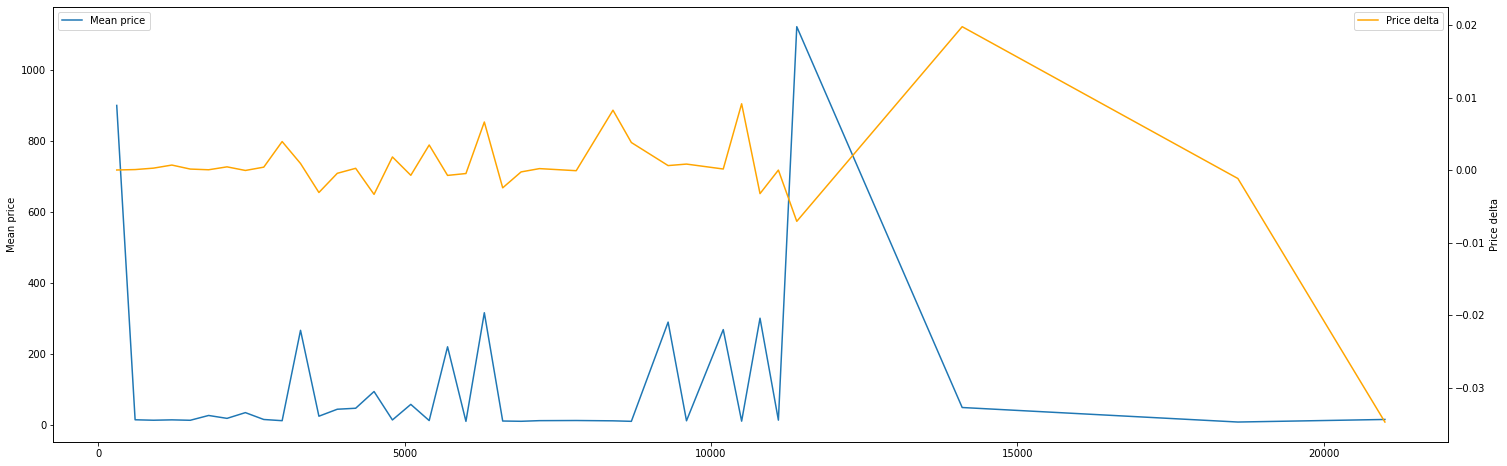

In [109]:
fig, ax1 = plt.subplots(figsize=(25,8))

ax1.plot(df_mean.index, df_mean.close)
ax1.set_ylabel("Mean price")
ax1.legend(['Mean price'], loc="upper left")

ax2 = ax1.twinx()
ax2.plot(df_mean.index, df_mean.lag_diff_price, color='orange')
ax2.grid(False)
ax2.set_ylabel('Price delta')
ax2.legend(['Price delta'], loc="upper right")

plt.show()

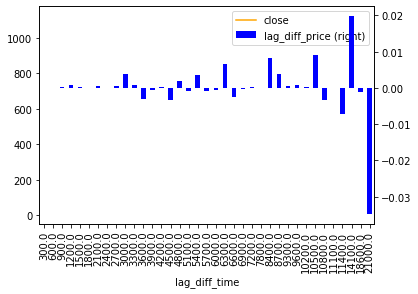

In [120]:
fig, ax = plt.subplots()

df_mean.plot(
    use_index=True,
    kind='line',
    y='close',
    ax=ax,
    color='orange'
)

df_mean.plot(
    use_index=True,
    y='lag_diff_price',
    kind='bar',
    ax=ax,
    secondary_y=True,
    color='blue'
)

plt.show()

<AxesSubplot:xlabel='lag_diff_time'>

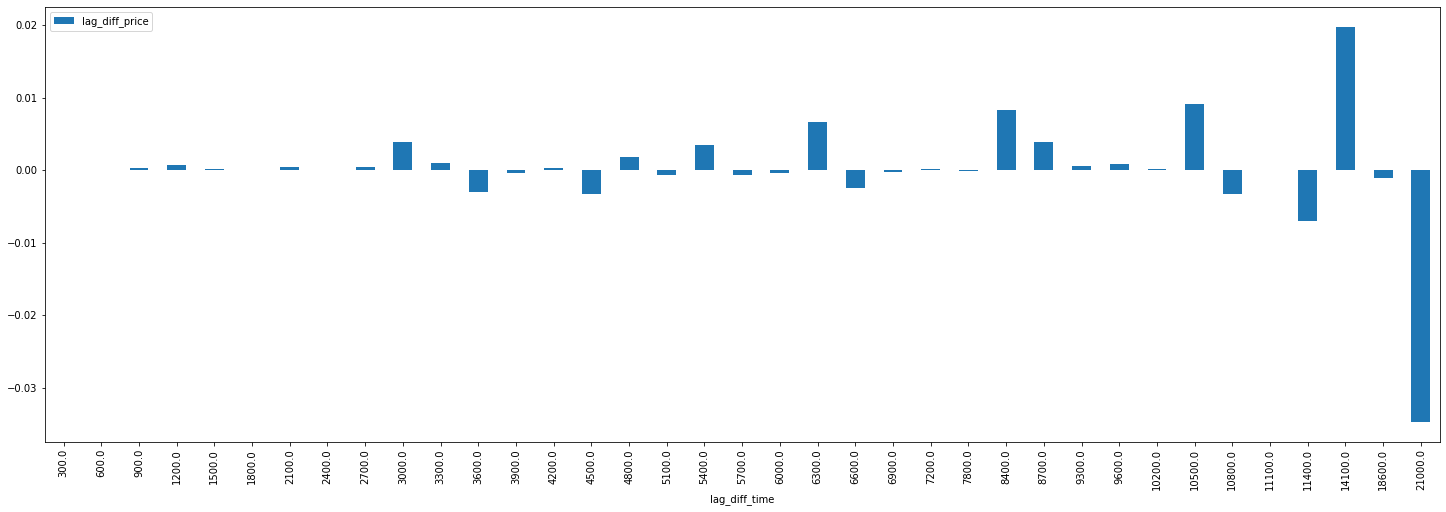

In [82]:
df[['lag_diff_time', 'lag_diff_price']]\
    .groupby('lag_diff_time').mean().plot.bar(figsize=(25, 8))

<AxesSubplot:xlabel='lag_diff_time'>

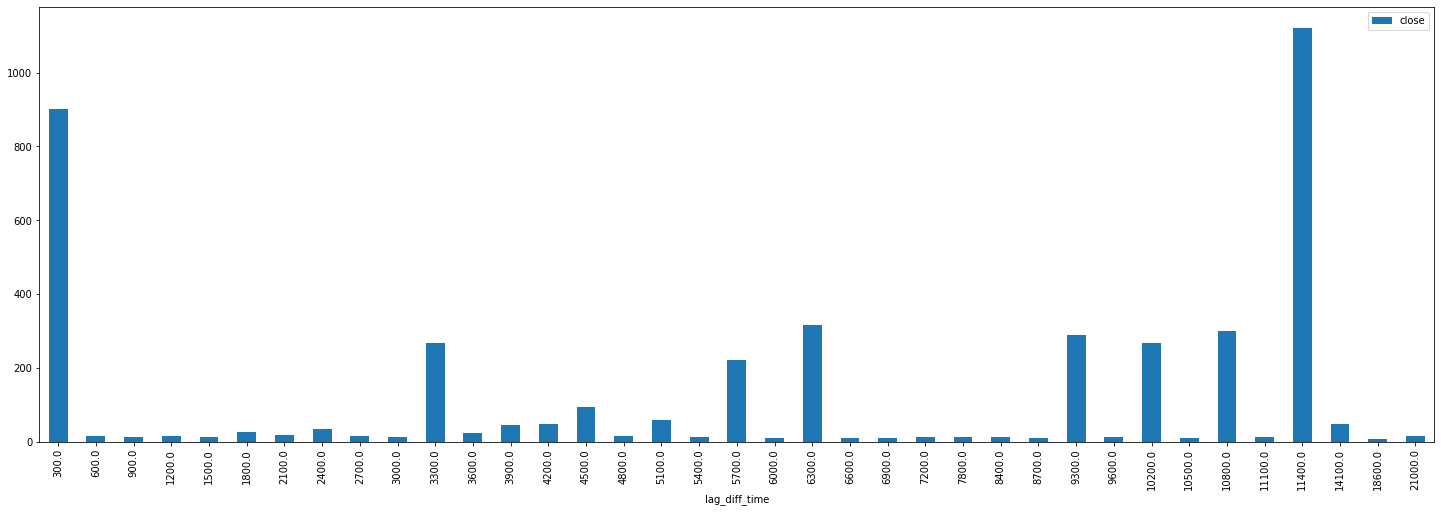

In [83]:
df[['lag_diff_time', 'close']]\
    .groupby('lag_diff_time').mean().plot.bar(figsize=(25, 8))

In [81]:
df[['lag_diff_time', 'close', 'lag_diff_price']]\
    .groupby('lag_diff_time').mean()

,close,lag_diff_price
lag_diff_time,,
300.0,900.227776,0.000013
600.0,14.949034,0.000070
900.0,13.666103,0.000269
1200.0,14.725101,0.000693
1500.0,13.526488,0.000140
1800.0,27.078390,0.000044
2100.0,18.905195,0.000446
2400.0,35.092241,-0.000052
2700.0,15.750606,0.000405
